# Notebook 3

## Decision Trees (ISLR Chapter 8)

This dataset using US Census data from the 2019 ACS 5 year survey along with COVID-19 vaccination rate data from the Louisiana Department of Health. Data is organized by census tract. The first portion of this Notebook is include the data cleaning and manipulation code. For decision tree regression modeling teaching puropses, please start at [Regression Trees - Why Use Them?](#start_here).

In [1]:
import os
import pandas as pd

In [2]:
dir_main = os.getcwd()

In [3]:
dir_cleaning = os.path.join(dir_main, 'data', 'cleaning')

In [4]:
lst_names = os.listdir(dir_cleaning)
lst_names

lst_temp = []
for name in lst_names: # Filter system files out
    if not name.startswith('.'):
        lst_temp.append(name)
lst_names = lst_temp

In [5]:
lst_dfs = []
for name in lst_names:
    df_temp = pd.read_csv(os.path.join(dir_cleaning, name), header=None)
    
    df_temp.drop(df_temp.index[0], inplace=True) # Delete unneeded header
    new_header = df_temp.iloc[0] # Grab the first row for the header
    df_temp = df_temp[1:] # Take the data less the header row
    df_temp.columns = new_header # Set the header row as the df header
    
    lst_dfs.append(df_temp)

/Users/steele/opt/anaconda3/envs/ISLR/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,54

In [6]:
from functools import reduce

In [7]:
df_merged = reduce(lambda x, y: pd.merge(x, y, on='id'), lst_dfs) # Combine all dataframes together

In [8]:
df_stats = df_merged[['id',
                      'Labor Force Participation 16 and Older Percent',
                      'Median Household Income',
                      'Black Percent',
                      'No Vehicle Household Percent', 
                      'Population High School Graduate or Equivalency or Higher Percent']]

In [9]:
df_vac = pd.read_csv(os.path.join(dir_main, 'data', '2021.06.28_Vaccinations by Tract.csv'))

In [10]:
# Create column with percent vaccination series completed out of total population for census tract
df_vac['SeriesCompPercent'] = df_vac['SeriesComp']/df_vac['Total_2018Pop'] 

In [11]:
# Add full tract code to vaccination tracts
tracts = df_vac['TractID']
geoid = []
for tract in tracts:
    geoid.append('1400000US' + str(tract))
df_vac['id']  = geoid    

In [12]:
df_vac_orig = df_vac.copy(deep=True)

# Limit to only Orleans Parish
df_vac = df_vac[df_vac.parish == 'Orleans']

In [13]:
df_vac = df_vac[['id', 'Lat', 'Long', 'SeriesInt', 'SeriesComp', 'SeriesCompPercent']]

In [14]:
df = df_vac.merge(df_stats, on='id', copy=False)

### Changing Data Type
As shown below, we've got a mixture of datatypes. We'll need to change these to float in order to start creating models. 

In [15]:
df.dtypes

id                                                                   object
Lat                                                                 float64
Long                                                                float64
SeriesInt                                                           float64
SeriesComp                                                          float64
SeriesCompPercent                                                   float64
Labor Force Participation 16 and Older Percent                       object
Median Household Income                                              object
Black Percent                                                        object
No Vehicle Household Percent                                         object
Population High School Graduate or Equivalency or Higher Percent     object
dtype: object

In [16]:
# The linear modeling will require int or float instead of objects,
# so we will convert the columns to numeric.
column_temp = df['id']
df.drop(columns='id', inplace=True)
df = df.apply(pd.to_numeric, errors='coerce') # Convert all columns to numeric
df['id'] = column_temp

df.dtypes

Lat                                                                 float64
Long                                                                float64
SeriesInt                                                           float64
SeriesComp                                                          float64
SeriesCompPercent                                                   float64
Labor Force Participation 16 and Older Percent                      float64
Median Household Income                                             float64
Black Percent                                                       float64
No Vehicle Household Percent                                        float64
Population High School Graduate or Equivalency or Higher Percent    float64
id                                                                   object
dtype: object

In [17]:
df.describe()

,Lat,Long,SeriesInt,SeriesComp,SeriesCompPercent,Labor Force Participation 16 and Older Percent,Median Household Income,Black Percent,No Vehicle Household Percent,Population High School Graduate or Equivalency or Higher Percent
count,177.000000,177.000000,168.000000,168.00000,168.000000,174.000000,170.000000,174.000000,172.000000,174.000000
mean,29.971739,-90.057728,1096.696429,1002.87500,0.456262,61.945402,48814.541176,56.397553,20.184876,85.506897
std,0.041055,0.056683,536.080081,488.38913,0.148525,11.515823,31899.207159,32.718965,14.593598,10.522432
min,29.898550,-90.135307,214.000000,190.00000,0.075517,0.000000,10288.000000,0.901172,0.000000,55.900000
25%,29.939842,-90.099388,746.250000,667.75000,0.346976,55.150000,25073.000000,24.274568,8.683670,78.625000
50%,29.965729,-90.070679,995.000000,908.50000,0.431049,62.450000,39654.000000,67.377099,17.044145,86.650000
75%,29.997370,-90.032219,1378.750000,1234.00000,0.576862,70.475000,66384.250000,85.722305,29.486389,94.950000
max,30.121422,-89.752693,3972.000000,3309.00000,1.157398,83.700000,170278.000000,98.889755,65.775401,100.000000


<a id='start_here'></a>
### Regression Trees - Why use them? 
Regression trees, unlike other forms of regression, works better when the data does not fit a logistic or linear model well. Regression trees also work well if there are outliers in the data and specifically are taillored to data that is clustered. However, just like any other form of regression, only with testing the data using <b>cross validation</b> will we be able to determine if our regression model is a good fit. We've got to build and test to be sure. 

As we can see below, our data for <code>Black Percent</code> would likely fit a linear model quite well, but we can also see that there would appear to be a few outliers in the data which may be better fit using decision tree regression. (Note: We are going to ignore the single outlier which shows a vaccination rate above 100% for the time being.)

In [18]:
import matplotlib.pyplot as plt

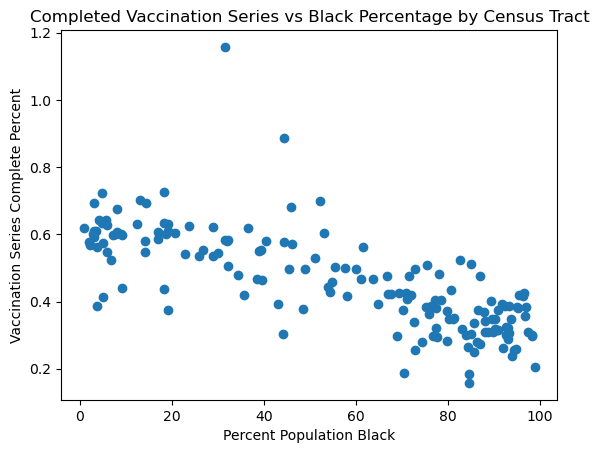

In [19]:
df_omit = df.dropna() # Drop rows with missing data

x = df_omit['Black Percent']
y = df_omit['SeriesCompPercent']

plt.scatter(x, y)
plt.title('Completed Vaccination Series vs Black Percentage by Census Tract')
plt.xlabel('Percent Population Black')
plt.ylabel('Vaccination Series Complete Percent')
plt.show()

Let's check our dataset to see if there are any predictors which show up as clustered when plotted. It looks like <code>Median Household Income</code> might have a couple clusters which indicate it's a good candidate for modeling with a regression tree. 

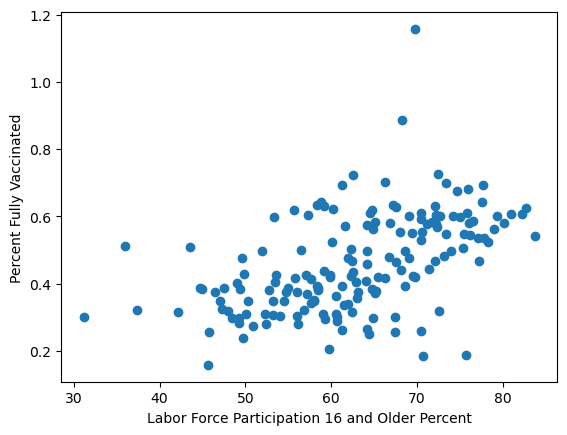

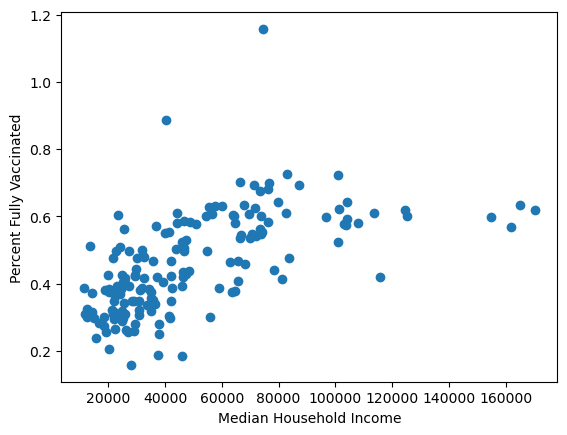

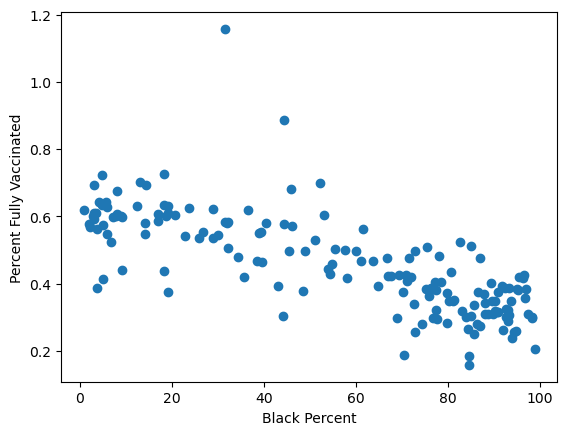

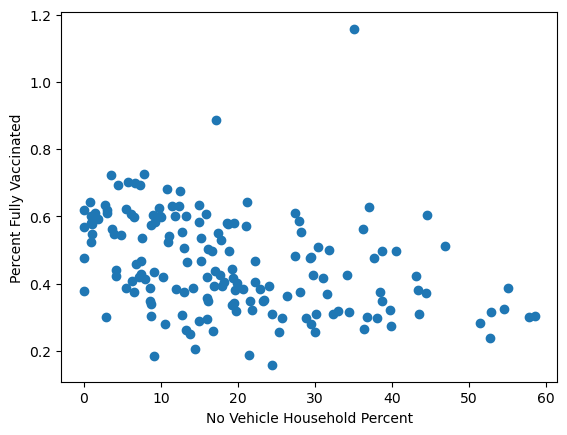

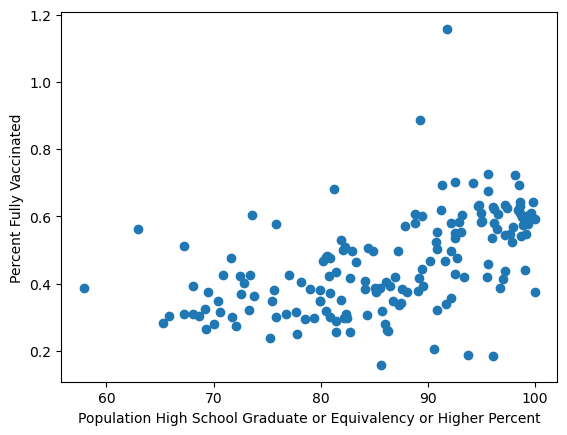

In [20]:
df_plots = df_omit[df.columns[5:10]]


for i, col in enumerate(df_plots.columns):
    plt.scatter(df_plots[col], df_omit['SeriesCompPercent'])
    plt.xlabel(df_plots[col].name)
    plt.ylabel('Percent Fully Vaccinated')
    plt.show()

The potential clusters have been indicated below in red.
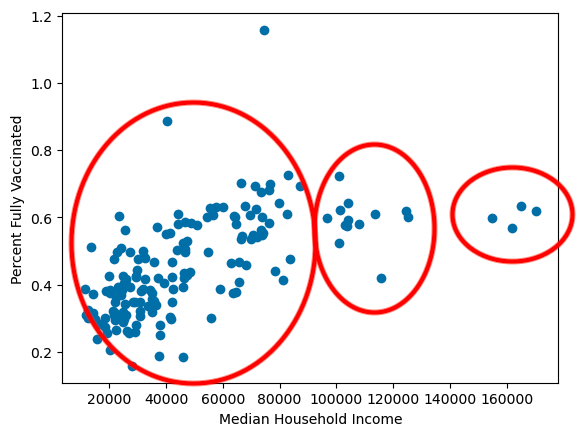

### Tree Terminology
Before we build our model, let's get familiar with how a tree is designed and how a model is fit to a tree. We start with the <b>root node (AKA root)</b>. Branching off from the root node are the <b>internal nodes (AKA nodes)</b> which terminate in <b>leaf nodes (AKA leaves)</b>.

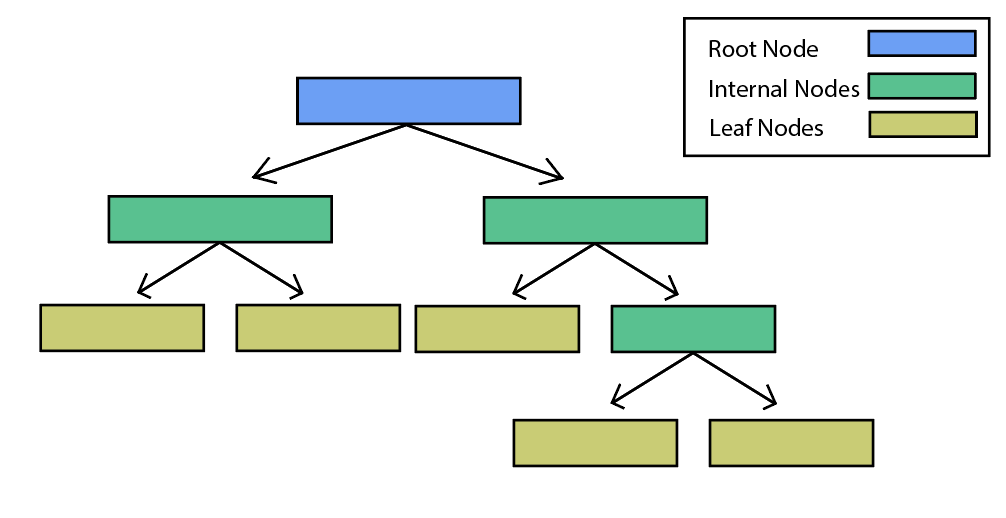

### Simplified Example
In order to understand how a regression tree is built, we'll start with a simplified example datset of the <code>Median Household Income</code> data. 

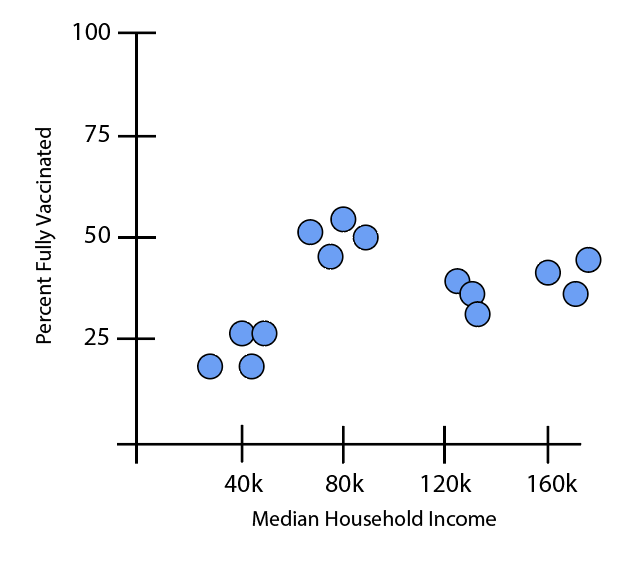

<p>The first thing the model will do is determine the root node. This is done by determining the <b>residual sum of squares (RSS)</b> between each point and determining which point had the smallest RSS. </p>

In the example below for the first two points, indicated by <font color="orange">orange dots</font>, have an average of 36k + 40k / 2 = 38k. This point will be used as the point we perform calculations on, indicated by the <font color="red">red dotted line</font>. We will make the average determined to be the potential root node.

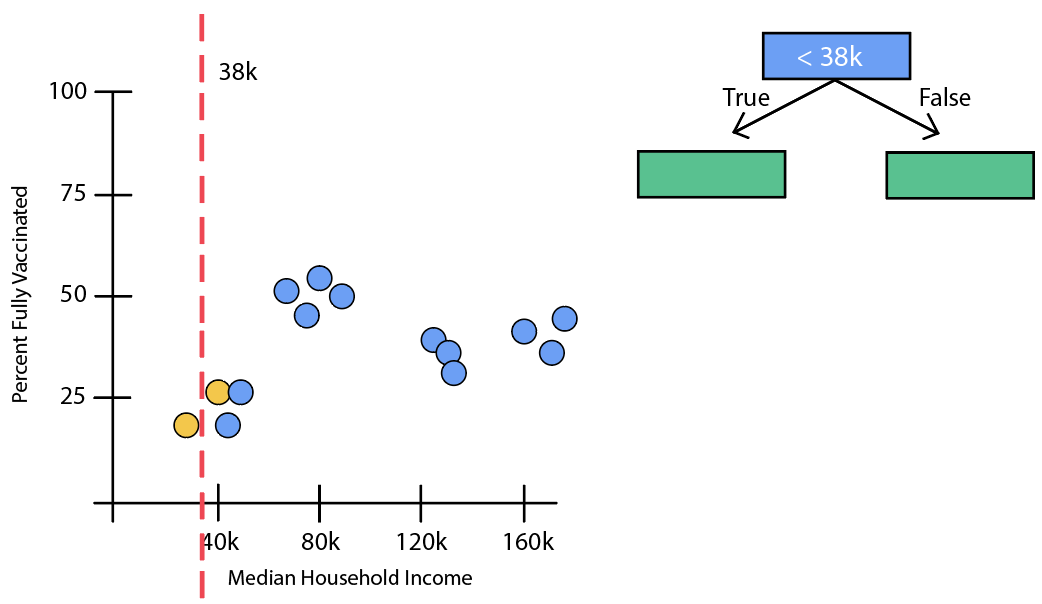

<p>Next all the points to the left and the right of the <font color="red">red dotted line</font> have the Y axis (Percent Fully Vaccinated) averaged. For the left, there is only one point, so the average is 20%. For the right we average all the points to the right which come to approximately 40%. This indicated by the <font color="green">green dashed lines</font>.</p>

<p>So with this, we have created the first simple tree. If the <code>Median Household Income</code> is &lt; 3.8k, we can state that this simple tree will predict the percent vaccinated will be 20%. If it is &gt; 38k, this tree would predict that the percent vaccinated would be 40%.</p>

<p>Of course this tree isn't a very good model. We can determine how good or bad this possible root node is by determining the <b>residual sum of squares</b>. 


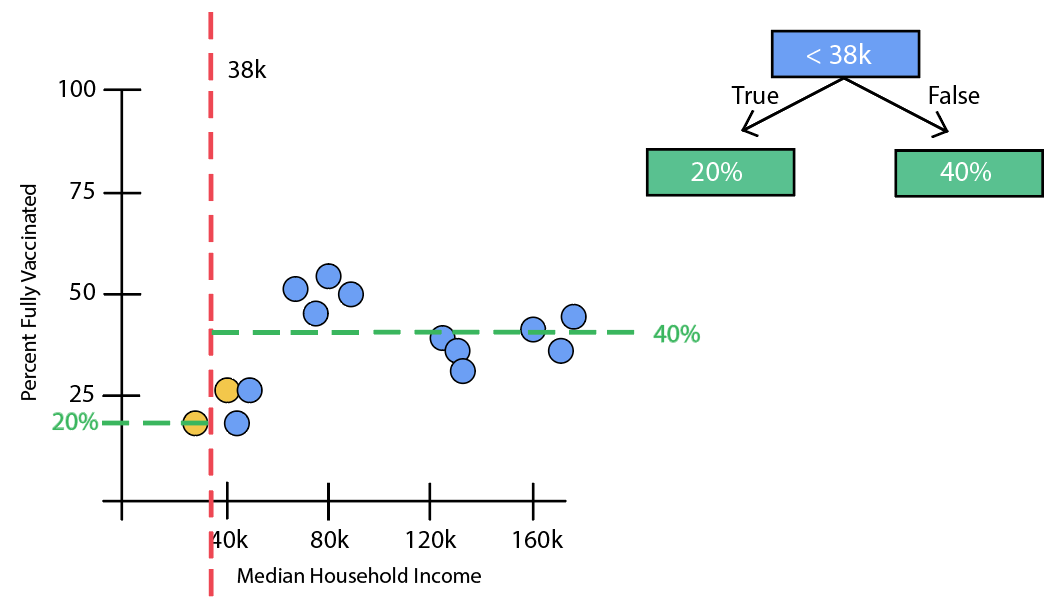

<p>For the right side, the residual for each point is calculated by determining how far each point is from the <font color="green">dotted green line</font>, indicated by dotted black lines. These values are then squared (in order to make sure they are all positive numbers). For the first point, this would be (25 - 40)<sup>2</sup>. The next point to the right would be (20-40)<sup>2</sup>. Then the next point to the right would be (25-40)<sup>2</sup>. Then the next would be (50-40)<sup>2</sup>, and so on and so forth until the last point. Then all of the points are added together added to get the <b>residual sum of squares</b> for the right portion.</p>

<p>After all the calculations are finished. The <b>RSS</b> for the right side was determined to be 1945.</p>

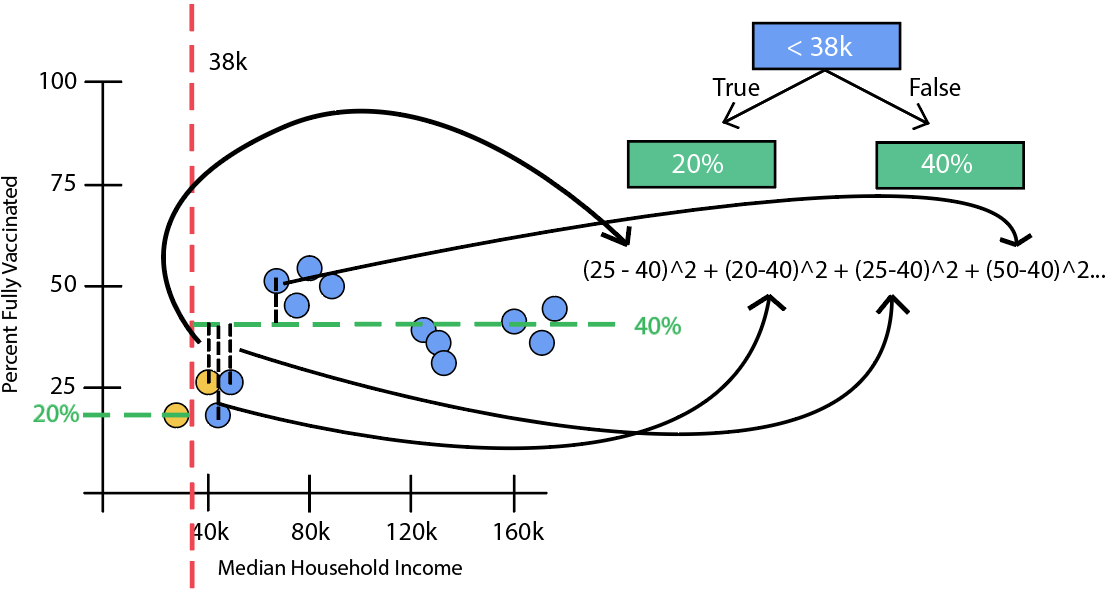

<p>To calculate the <b>RSS</b> for the left portion, we don't need to do much. Because there is only one point, the point sits at the average of 20%. So the <b>RSS</b> is caculated to be (20 - 20)<sup>2</sup> = 0</p>

<p>Next, we add the left and the right side together to get the <b>RSS</b> for this potential root.</p>
<p> 1945 + 0 = 1945</p>

#### Next Step

Then we move on for the average between the next two points, as shown below, and we determine the <b>RSS</b> for the average between those two points of 41k on the right and left side and add them together to get the <b>RSS</b> for this potential root node. 

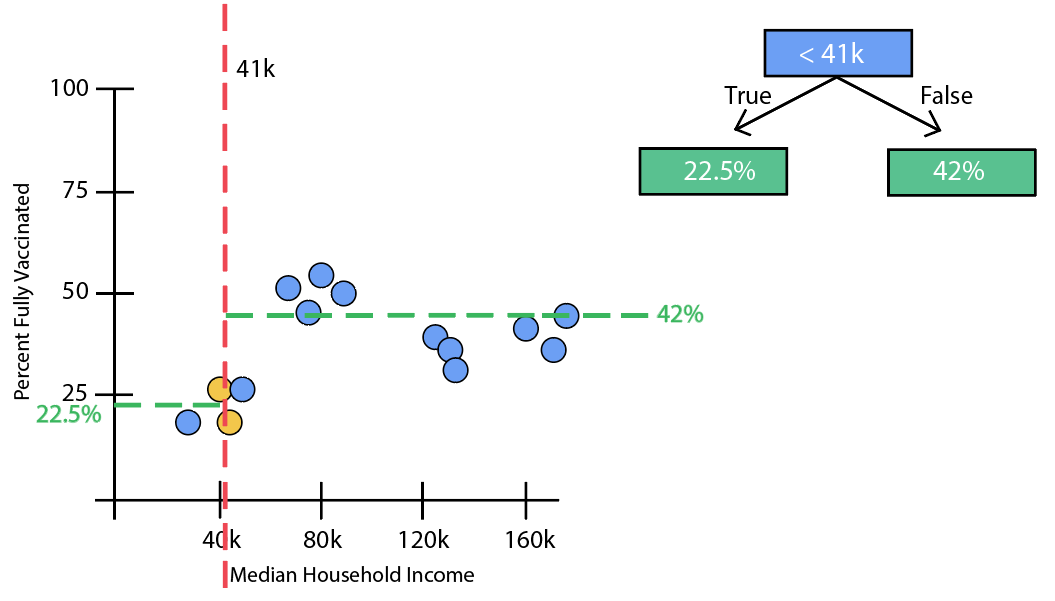

We would continue this process from left to right to determine what all the <b>RSS</b>s are. 

#### BUT WHAT IS THIS ALL TELLING US?

Okay okay. This is getting a bit long winded, right? Well, it's close to being finished. <u>After we determine all the <b>RSS</b>s for the average between each <code>Median Household Income</code> point, the average with the smallest <b>RSS</b> will become the root node for the model.</u>

In this simplified example, our root node was determined to be between the two points below with the average between them being 100k. This average had the lowest <b>RSS</b> will be our <b>root node</b>.

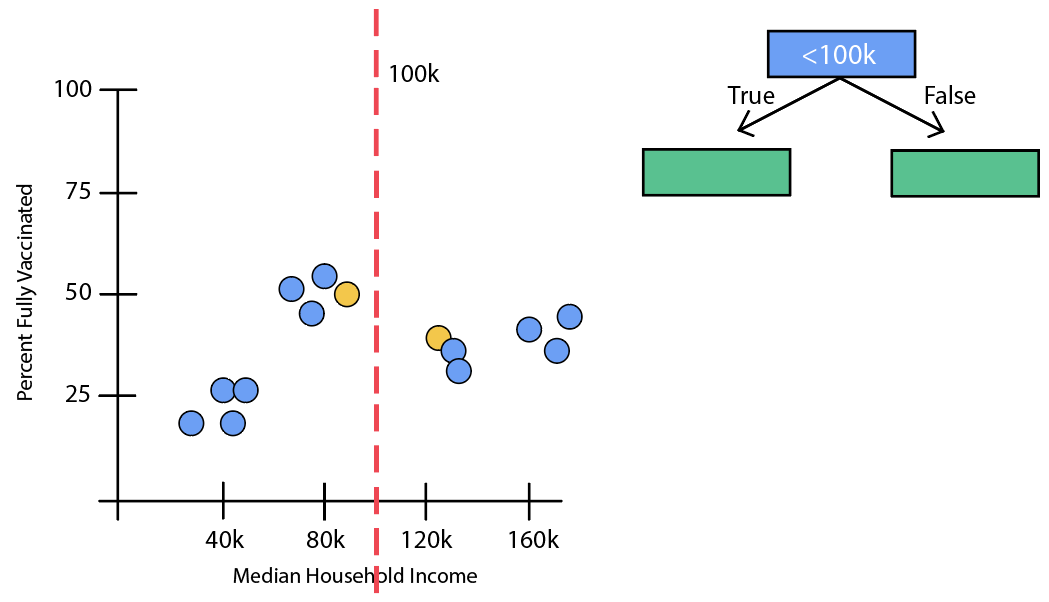

From there the exact same process is repeated. On each side which becomes a new node as shown below. 

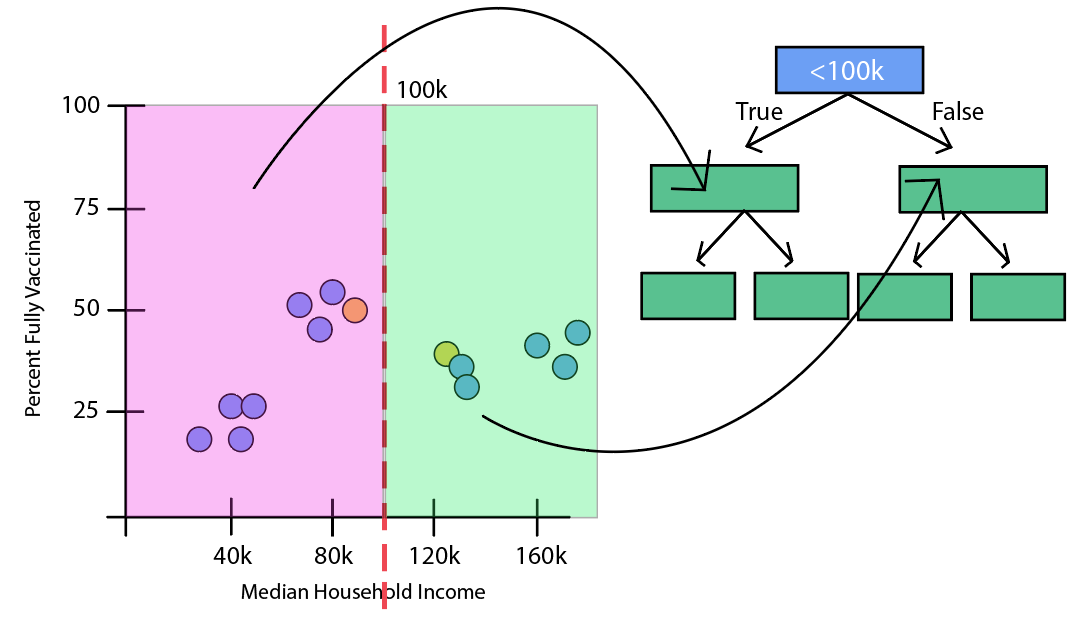

<p>The process is run again and again until it is not able to be run any longer, resulting in the final <b>leaves</b> of the regression tree.</p>

<p>Doing this by hand would be a long and tedious task. Luckily we have computers to do the hard work for us!</p>

### Using <code>SciKitLearn</code> to Create a Decision Tree

In [21]:
df_omit = df.dropna() # Drop rows with missing data

In [22]:
'''predictor_cols = ['Labor Force Participation 16 and Older Percent', 
                  'Median Household Income', 
                  'Black Percent',
                  'No Vehicle Household Percent',
                  'Population High School Graduate or Equivalency or Higher Percent']
'''

predictor_cols = ['Median Household Income'] # We are only going to be using this predictor

X = df_omit[predictor_cols] # Features
y = df_omit.SeriesCompPercent # Target variable

### Fitting the Model

In [23]:
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor(max_leaf_nodes=100, min_samples_leaf=1) # Create decision tree classifier object
regr = regr.fit(X, y) # Fit the model

### Displaying the Tree Visually

In [24]:
from graphviz import Source
from IPython.display import SVG
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydot

tree = Source(export_graphviz(regr, out_file=None, feature_names=predictor_cols))
SVG(tree.pipe(format='svg')),

(<IPython.core.display.SVG object>,)

Note: GraphViz may not install poperly, and you may get the error <code>GraphViz's executables not found</code>. On MacOS or Linux, this can be solved by installing <a href="https://brew.sh">Brew</a> and then running <code>brew install graphviz</code> in the terminal. 

In [25]:
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data,
                    feature_names=features, 
                    class_names = classn, 
                    filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [26]:
graph, = print_tree(regr, features=predictor_cols)

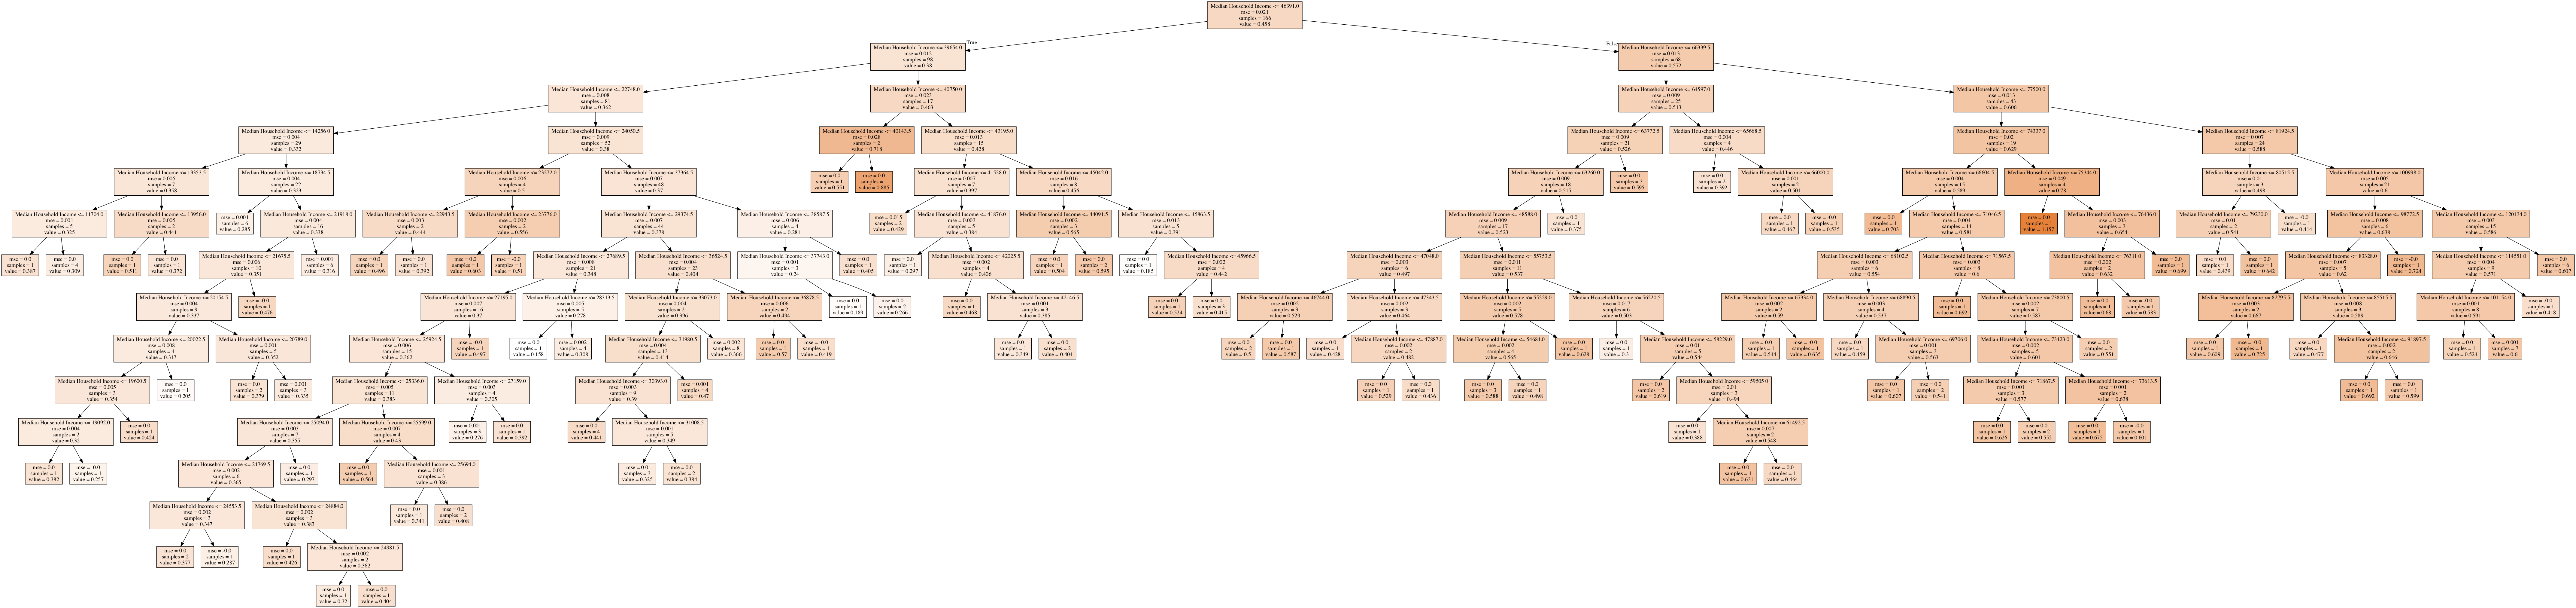

In [27]:
Image(graph.create_png())
#Note: MSE is simply the RSS devided by the degrees of freedom

Overfit means low bias but high variance, so it won't work well with new data. As the example above shows, some of the leaves only have one or two datapoints in them. (Right click → "Open image in new tab" to see the tree in detail.) This is to overfit. This model would not be the best at predicting anything outside of the model itself. Try changing the <code>max_leaf_nodes</code> and/or <code>min_samples_leaf</code> parameters to see what you can come up with to make sure the dat is not overfit. 

### How About Mulitiple Predictor Variables?

Great of you to ask! For models with more than one predictor, minimum SSR (sum of squared residuals AKA RSS) is calculated for each predictor; predictor with lowest RSS (residual sum of squares) is chosen for the root node. Then the process is repeated at each node as described above.

### Evaluating Performance of a Decision Tree
<p>Let's split the data and see how to determine how well the data is fit.</p>

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test

Here we are initializing the model and setting the <code>min_samples_leaf</code> to 5, so that we have a minimum of 5 samples in each leaf as to not overfit.

In [51]:
regr = DecisionTreeRegressor(max_leaf_nodes=100, min_samples_leaf=5) 
regr = regr.fit(X_train, y_train) # Fitting with the training data

Now we will predict y, which is the percent of the census tract that is fully vaccinated, using the remaining 20% of the X, which is the median household income.

In [49]:
y_pred = regr.predict(X_test) 

df_predict = pd.DataFrame({'Actual':y_test, 'Predicted:':y_pred})
df_predict

,Actual,Predicted:
48,0.257857,0.290829
51,0.380500,0.368633
157,0.570045,0.346587
71,0.316078,0.353132
159,0.444181,0.368633
11,0.251361,0.346587
83,0.496864,0.290829
39,0.346669,0.290829
106,0.504345,0.494848
14,0.188732,0.346587


Most of these seem relatively close, but let's use some metrics to determine how close our predictions are. The MAPE is 24%. The MAPE tells us the average difference between the predicted and actual value. Generally speaking, less than 10% is excellent and less than 20% is good. We are at 24%, so this is not too shabby considering that we didn't think this was a good predictor at all. Our model fits reasonably well for predictions. We are at least going to get in the ballpark. 

In [50]:
from sklearn import metrics
import numpy as np

mean = df_omit['SeriesCompPercent'].mean()
mae = metrics.mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test))*100
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Mean Absolute Error:', mae)
print('Mean Absolute Percentage Error:', mape)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 0.09662124043893938
Mean Absolute Percentage Error: 24.8706499070565
Mean Squared Error: 0.018761259306014532
Root Mean Squared Error: 0.13697174637864018


It would be good at this point to use cross-validation techniques in order to better determine how accurate our predictions are. 

### Random Forests are Better
<p>So a simple decsion tree is okay, but it's not all that great at predicting outside of the dataset used. To fix this, we'll build a <b>random forest</b> which is basically a bunch of decision trees put together. The process behind the scenes that Python does for us is a bit beyond what we want to cover in this notebook, we'll just go over how to build a <b>random forest</b> model and evaluate it. We'll use all the predictor variables this time.</p>

In [126]:
predictor_cols = ['Labor Force Participation 16 and Older Percent', 
                  'Median Household Income', 
                  'Black Percent',
                  'No Vehicle Household Percent',
                  'Population High School Graduate or Equivalency or Higher Percent']


#predictor_cols = ['Median Household Income'] # We are only going to be using this predictor

X = df_omit[predictor_cols] # Features
y = df_omit.SeriesCompPercent # Target variable

In [118]:
'''predictor_cols = ['Labor Force Participation 16 and Older Percent', 
                  'Median Household Income', 
                  'Black Percent',
                  'No Vehicle Household Percent',
                  'Population High School Graduate or Equivalency or Higher Percent']
'''

predictor_cols = ['Median Household Income'] # We are only going to be using this predictor

X = df_omit[predictor_cols] # Features
y = df_omit.SeriesCompPercent # Target variable

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test

In [128]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000, random_state=42)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [151]:
predictions = rf.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Mean Absolute Error:', mae)
print('Mean Absolute Percentage Error:', mape)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Accuracy:', 1-mape)

Mean Absolute Error: 0.09662124043893938
Mean Absolute Percentage Error: 0.24870649907056505
Mean Squared Error: 0.018761259306014532
Root Mean Squared Error: 0.13697174637864018
Accuracy: 0.7512935009294349


That's about it! Just with a few lines of code, we can create a random forest, which by hand would be a very lengthy process.